# AllLife Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Key Questions

- Exploratory Data Analysis to understand the data better 
- Data preprocessing to prepare the data for modeling
- KMeans and Hierarchical clustering cluster analysis and profiling 
- Comparing K-means vs Hierarchical Clustering
- Actional insights and recommendation to bank 


### Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).
 
**Data Dictionary**
- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist, cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

#Format:
pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline

### Read the dataset

In [2]:
# loading the dataset
data = pd.read_excel("Credit_Card_Customer_Data.xlsx")

#### View the random 10 rows of the dataset.

In [3]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
547    548         38125             26000                   4   
353    354         94437              9000                   5   
499    500         65825             68000                   6   
173    174         38410              9000                   2   
241    242         81878             10000                   4   
341    342         70779             18000                   4   
647    648         79953            183000                   9   
218    219         28208             19000                   3   
120    121         16577             10000                   4   
134    135         31256             13000                   4   

     Total_visits_bank  Total_visits_online  Total_calls_made  
547                  5                    2                 4  
353                  4                    1                 3  
499                  4                    2                 2  
173                  1                    5                 8  
241                  5                    1                 3  
341                  3                    2                 0  
647                  0                    9                 2  
218                  1                    5                 7  
120                  2                    4                 6  
134                  1                    5                 7

### Dataset Summary

#### Shape of the data

In [4]:
print('There are {row} records, and {col} columns in the dataset'.format(row=data.shape[0], col=data.shape[1]))

There are 660 records, and 7 columns in the dataset


* The dataset has 660 rows and 7 columns 

In [5]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

### Check the data types of the columns for the dataset.

In [6]:
# checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observations**

- All the variables are numeric variables.
- There are no missing values present in any of the variables. 

### Summary of the dataset.

In [7]:
# Let's look at the statistical summary of the data
df.describe(include="all").T

count       mean        std        min        25%  \
Sl_No               660.0000   330.5000   190.6699     1.0000   165.7500   
Customer Key        660.0000 55141.4439 25627.7722 11265.0000 33825.2500   
Avg_Credit_Limit    660.0000 34574.2424 37625.4878  3000.0000 10000.0000   
Total_Credit_Cards  660.0000     4.7061     2.1678     1.0000     3.0000   
Total_visits_bank   660.0000     2.4030     1.6318     0.0000     1.0000   
Total_visits_online 660.0000     2.6061     2.9357     0.0000     1.0000   
Total_calls_made    660.0000     3.5833     2.8653     0.0000     1.0000   

                           50%        75%         max  
Sl_No                 330.5000   495.2500    660.0000  
Customer Key        53874.5000 77202.5000  99843.0000  
Avg_Credit_Limit    18000.0000 48000.0000 200000.0000  
Total_Credit_Cards      5.0000     6.0000     10.0000  
Total_visits_bank       2.0000     4.0000      5.0000  
Total_visits_online     2.0000     4.0000     15.0000  
Total_calls_made        3.0000     5.0000     10.0000

**Observations**

- There are 660 rows and no missing values in any feature.
- Sl.No and Customer_Key feature will anyway be removed as it won't help much in analysis
- Credit limit average is around 35K with 50% of customers having a credit limit less than 18K. So, this feature is heavily right skewed. Also the Standard deviation is 37K which is also huge.
- Credit Card count ranges from 1 to 10 cards with an avg of 5 and also 75% of customers have upto 6 only.
- On average, most customer interactions are through calls, then online. Also, some customers never contacted/visited the bank.

## Data PreProcessing

In [8]:
# dropping the serial no. column as it does not provide any information
df.drop(["Sl_No"], axis=1, inplace=True)

In [9]:
# checking for missing values
df.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
#Checking for number of unique values in each variables
df.nunique()

Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

* It looks like there are 5 duplicate customer key values present in the dataframe. Lets analyze the records

In [12]:
data[data['Customer Key'].isin(data[data['Customer Key'].duplicated()]['Customer Key'].tolist())].sort_values('Customer Key')

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000                   4   
432    433         37252             59000                   6   
4        5         47437            100000                   6   
332    333         47437             17000                   7   
411    412         50706             44000                   4   
541    542         50706             60000                   7   
391    392         96929             13000                   4   
398    399         96929             67000                   6   
104    105         97935             17000                   2   
632    633         97935            187000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
48                   0                    2                 8  
432                  2                    1                 2  
4                    0                   12                 3  
332                  3                    1                 0  
411                  5                    0                 2  
541                  5                    2                 2  
391                  5                    0                 0  
398                  2                    2                 2  
104                  1                    2                10  
632                  1                    7                 0

* Its not necessary to remove the Customer Key duplicate values as its wont impact much
* Also this key column will be removed for further classification analysis
* If at all there are some duplicate records/rows persent in the data, it wont impact much as we are going to cluster the records. 

In [13]:
# Subseting the data for further analysis
subset_df = df.drop("Customer Key", axis=1)

In [14]:
subset_df.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [15]:
num_cols = subset_df.select_dtypes(include=np.number).columns.tolist()
num_cols

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [16]:
value_count_cols = ['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']
for column in value_count_cols:
    print(df[column].value_counts())
    print("-" * 50)

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64
--------------------------------------------------
2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64
--------------------------------------------------
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
10      6
12      6
8       6
11      5
13      5
9       4
14      1
6       1
Name: Total_visits_online, dtype: int64
--------------------------------------------------
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64
--------------------------------------------------


**Observation**

- Total Credit Card: 151 customers have 4 credit cards and only 19 have 10 credit cards
- Total Bank Visits: Max of 158 customers visited bank twice and 100 customers never visited bank with 112 visited atleast once
- Total Online Visits: 144 customers never visited, 109 visited only once and 189 visited twice. 
- Total Calls made: 97 customers never called bank and max of 108 customers called 4 times. 

## EDA

### Univariate Analysis

In [17]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

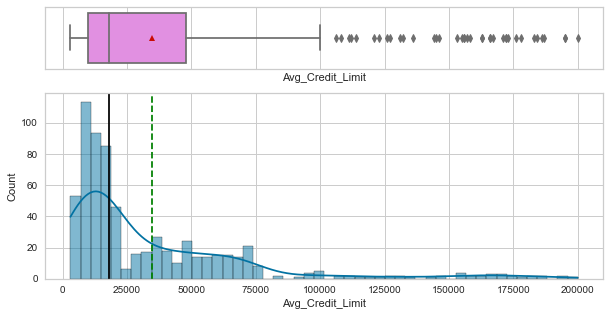

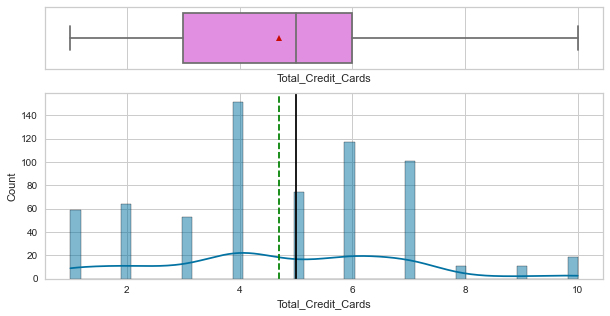

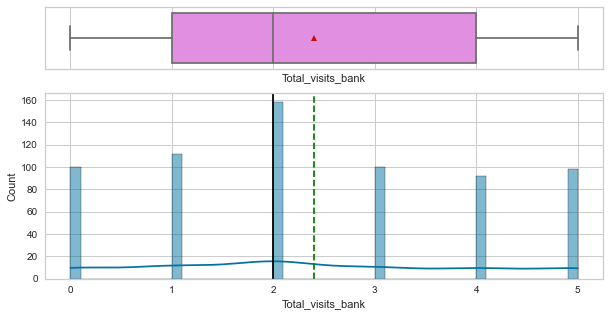

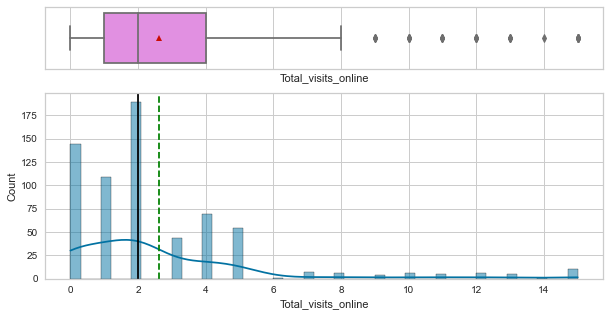

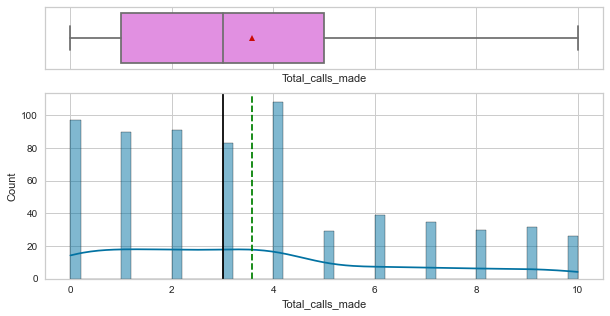

In [18]:
# selecting numerical columns
for item in num_cols:
    histogram_boxplot(subset_df, item, bins=50, kde=True, figsize=(10, 5))

In [19]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

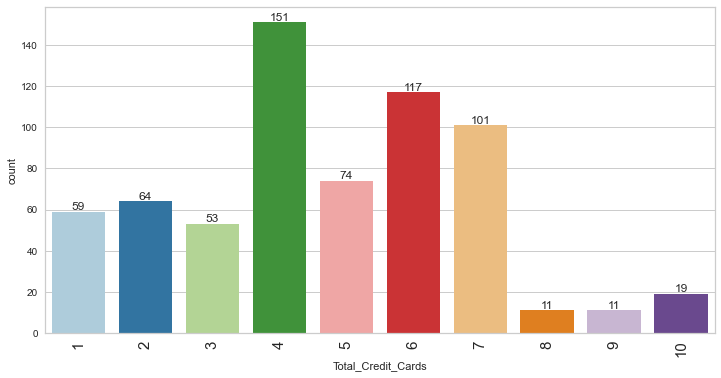

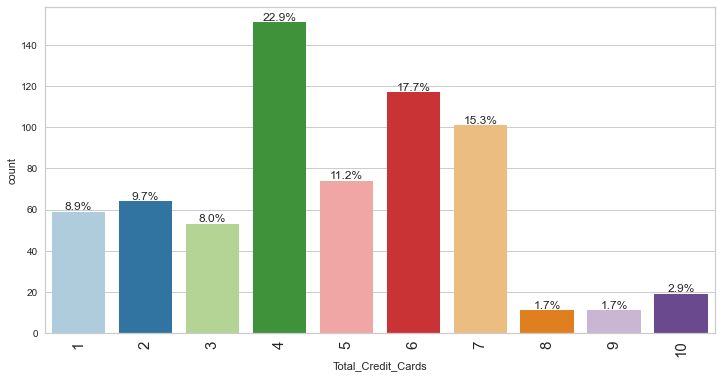

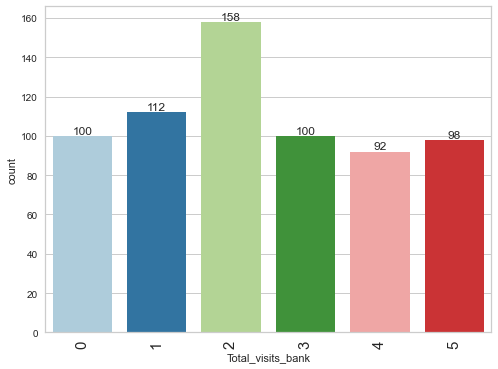

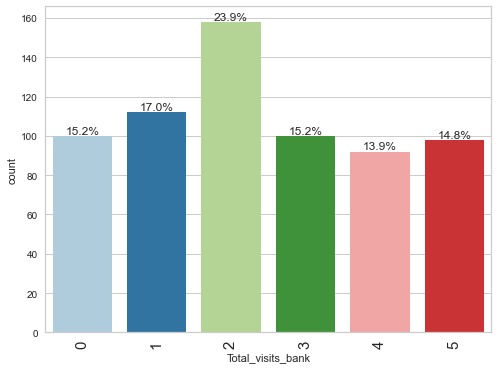

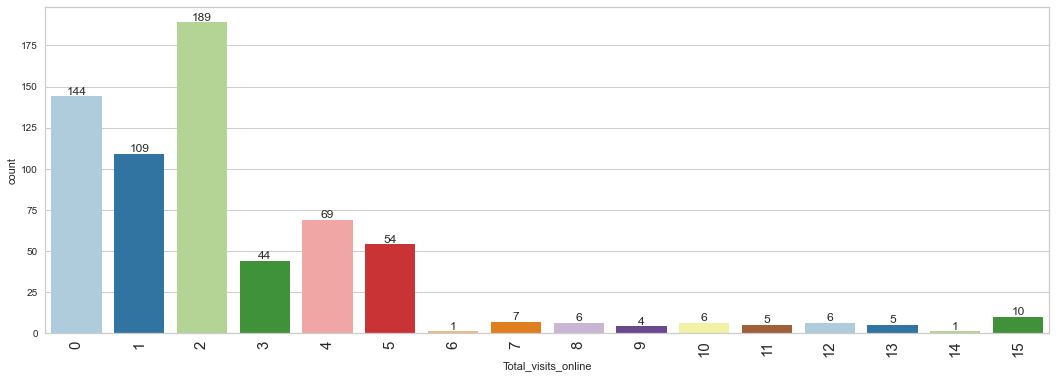

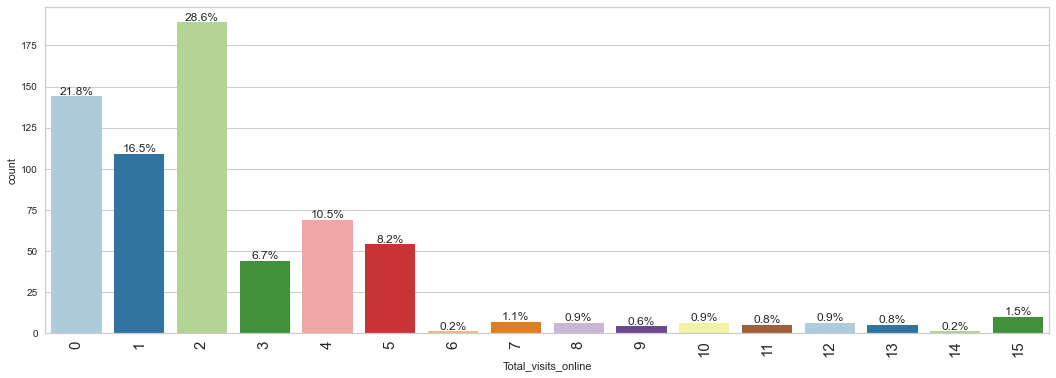

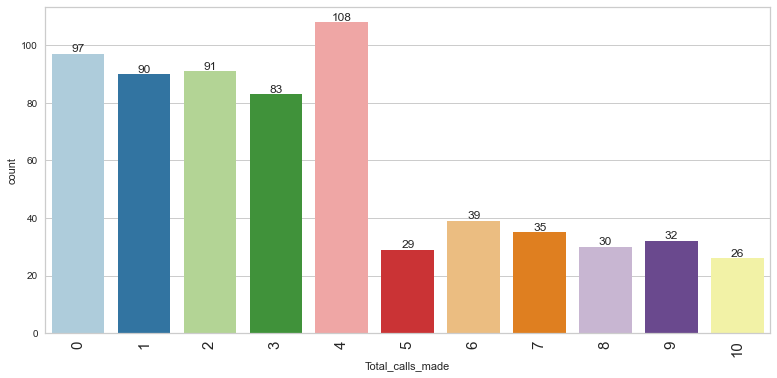

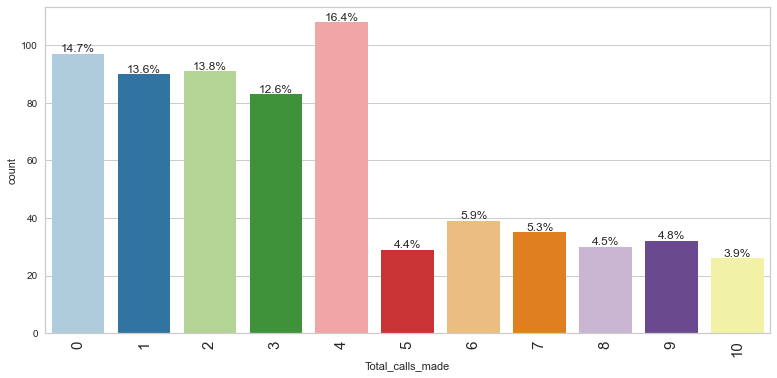

In [20]:
for i in range(len(value_count_cols)):
    labeled_barplot(data, value_count_cols[i])
    labeled_barplot(data, value_count_cols[i], perc=True)

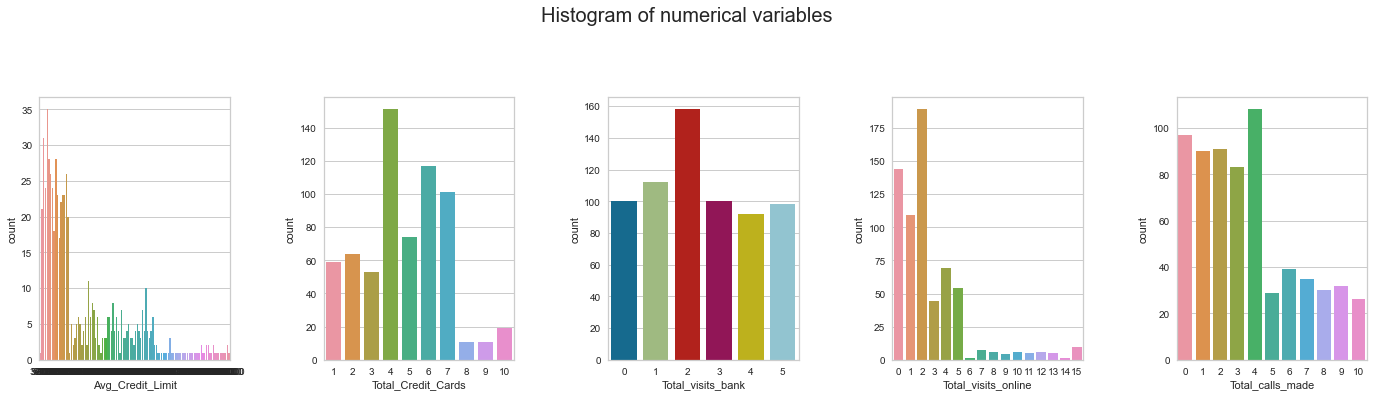

In [21]:
all_col = subset_df.iloc[:,:].columns.tolist()
fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.countplot(ax=axes[ii],x=subset_df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=4.0)

In [22]:
## Number of customers who used all three services 
subset_df[(subset_df['Total_calls_made']!=0) & (subset_df['Total_visits_bank']!=0) & (subset_df['Total_visits_online']!=0)].count()

Avg_Credit_Limit       356
Total_Credit_Cards     356
Total_visits_bank      356
Total_visits_online    356
Total_calls_made       356
dtype: int64

In [23]:
## Number of customers who never used all three services 
subset_df[(subset_df['Total_calls_made']==0) & (subset_df['Total_visits_bank']==0) & (subset_df['Total_visits_online']==0)].count()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [24]:
from pandas_profiling import ProfileReport

profile = ProfileReport(subset_df)

In [25]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Observation of Univariate Analysis

- Many outliers in average credit limit. High credit customers are causing skewness.
- Majority of customers have 4 credit cards and visited bank & online twice 
- Online visits are mostly between 1 and 4 with some outliers with more than 7 and above.
- There are multiple peaks in credit cards, visits online, total calls.
- Every customer have used either of the options to contact bank 
- 356 customers used all 3 banking options (calls / online / visited) which is more than half of our customers. 

**Advantages of Univariate Analysis**

* Helps to check the distribution/spread of the data primarily using histograms and box plots.

* Also Numerical feature can be plot using different options like violin plot and cumulative density distribution plot.

* Best way to understand data before starting the analysis or modeling.

### Bivariate Analysis

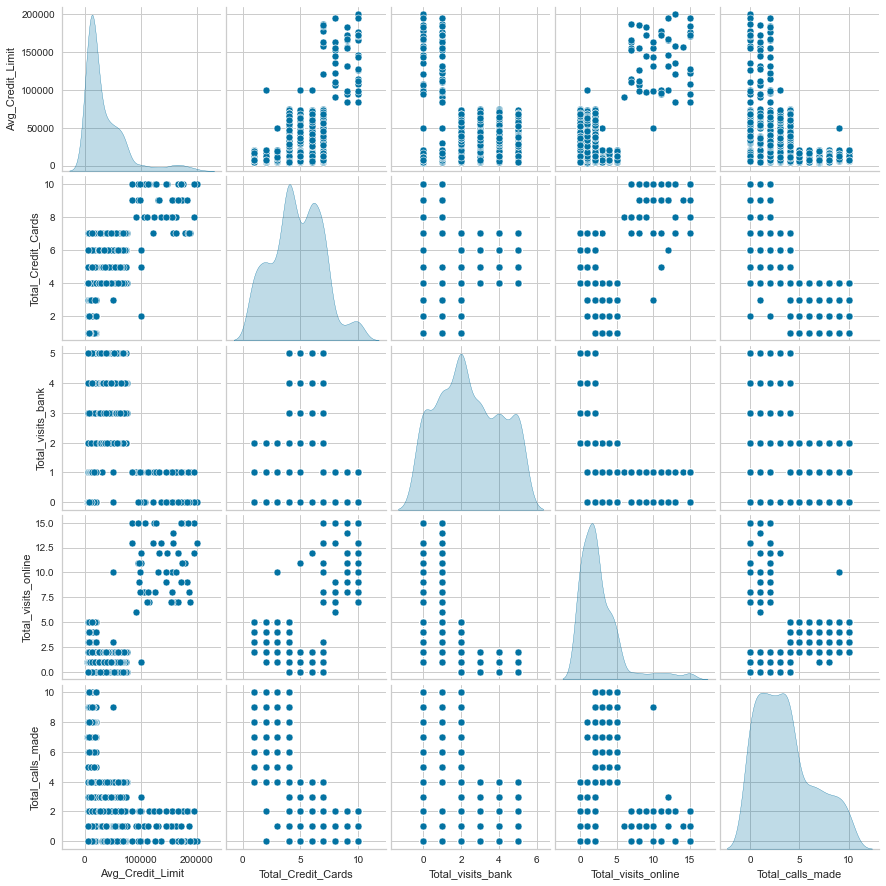

In [26]:
sns.pairplot(subset_df, diag_kind='kde');

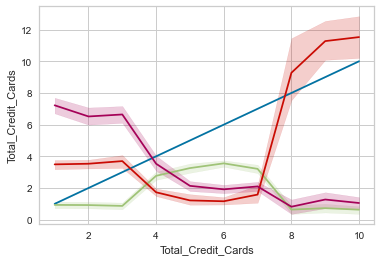

In [27]:
for i in range(len(value_count_cols)):
    sns.lineplot(subset_df['Total_Credit_Cards'],subset_df[value_count_cols[i]])

**Let's check for correlations.**

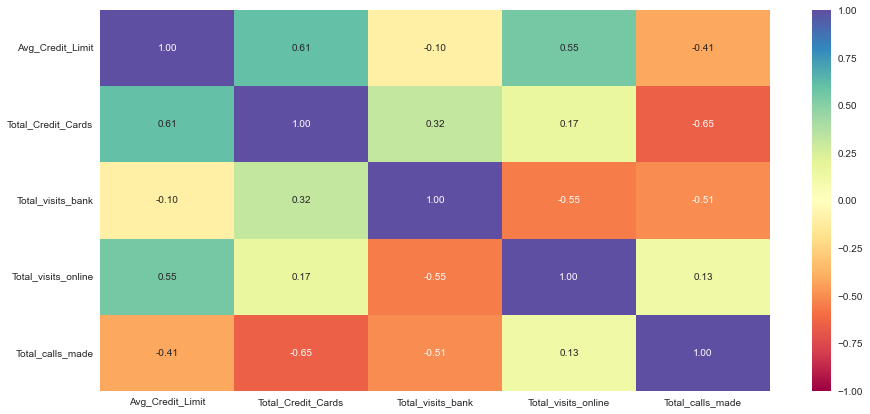

In [28]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    subset_df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### Observations on Bivariate Analysis


- Average Credit Limit has slightly positive correlation with Total Credit Cards
- Total Number of Visits Online has slightly negative correlation with Total Calls Made
- Total Credit Cards and Total Calls Made are negatively correlated
- Total Visits Online is also negatively correlated with Total Visits to Bank
- One intresting observation is calls made to bank is reducing as the number of credit cards increased
- Customers who have less credit cards like 1, 2 or 3 are calling bank frequently.
- Vists to bank is more for customers having credit cards between 4 to 7
- Also Visiting online customers have more credit cards 8 to 10

### Missing Values Treatment

In [29]:
subset_df.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

* There are no missing values in any column to treat before modelling

### Outliers Treatment

**Let's find the percentage of outliers, in each column of the data, using IQR.**

**Treating outliers**

We will cap/clip the minimum and maximum value of these columns to the lower and upper whisker value of the boxplot found using  **Q1 - 1.5*IQR** and **Q3 + 1.5*IQR**, respectively.

**Note**: Generally, a value of 1.5 * IQR is taken to cap the values of outliers to upper and lower whiskers but any number (example 0.5, 2, 3, etc) other than 1.5 can be chosen. The value depends upon the business problem statement.

In [30]:
# Finding the 25th percentile and 75th percentile for the numerical columns.
Q1 = data[num_cols].quantile(0.25)
Q3 = data[num_cols].quantile(0.75)

IQR = Q3 - Q1  # Inter Quantile Range (75th percentile - 25th percentile)

lower_whisker = (
    Q1 - 1.5 * IQR
)  # Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper_whisker = Q3 + 1.5 * IQR

In [31]:
# Percentage of outliers in each column
((subset_df[num_cols] < lower_whisker) | (subset_df[num_cols] > upper_whisker)).sum() / subset_df.shape[
    0
] * 100

Avg_Credit_Limit      5.9091
Total_Credit_Cards    0.0000
Total_visits_bank     0.0000
Total_visits_online   5.6061
Total_calls_made      0.0000
dtype: float64

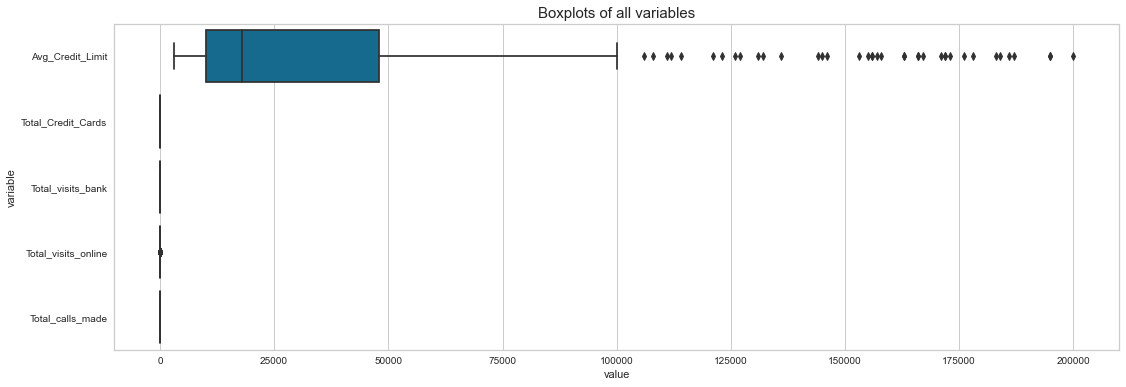

In [32]:
# Plotting Boxplots of all our features to get idea of distribution and outliers
plt.figure(figsize=(18,6))
sns.boxplot(x="value", y="variable", data=pd.melt(subset_df))
plt.title('Boxplots of all variables', size=15)
plt.show()

In [33]:
Q1 = subset_df["Avg_Credit_Limit"].quantile(0.25)  # 25th quantile
Q3 = subset_df["Avg_Credit_Limit"].quantile(0.75)  # 75th quantile
IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker)
print(upper_whisker)

-47000.0
105000.0


In [34]:
subset_df.loc[subset_df["Avg_Credit_Limit"] > 105000.0].sort_values("Avg_Credit_Limit", ascending=False)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
630            200000                  10                  0   
650            195000                  10                  1   
631            195000                   8                  0   
632            187000                   7                  1   
646            186000                   7                  0   
639            184000                   7                  1   
647            183000                   9                  0   
624            178000                   7                  0   
622            176000                  10                  1   
637            173000                   9                  1   
658            172000                  10                  1   
654            172000                  10                  1   
645            171000                  10                  0   
659            167000                   9                  0   
621            166000                   9                  1   
623            166000                  10                  0   
614            163000                   8                  1   
633            163000                   7                  1   
619            158000                   7                  0   
612            157000                   9                  1   
652            156000                   8                  1   
626            156000                   9                  1   
629            155000                   8                  0   
638            153000                   8                  1   
627            146000                  10                  0   
657            145000                   8                  1   
641            144000                  10                  0   
617            136000                   8                  0   
651            132000                   9                  1   
615            131000                   9                  1   
644            127000                  10                  1   
636            126000                  10                  1   
640            123000                   8                  1   
618            121000                   7                  0   
635            114000                  10                  1   
649            112000                  10                  1   
648            111000                   8                  1   
620            108000                  10                  0   
634            106000                   8                  0   

     Total_visits_online  Total_calls_made  
630                   13                 0  
650                   12                 2  
631                   15                 0  
632                    7                 0  
646                    8                 1  
639                   15                 2  
647                    9                 2  
624                   11                 0  
622                   15                 2  
637                   11                 0  
658                   15                 0  
654                    9                 1  
645                   15                 0  
659                   12                 2  
621                   12                 2  
623                    7                 0  
614                    7                 1  
633                   10                 1  
619                   13                 0  
612                   14                 1  
652                    8                 0  
626                   10                 2  
629                    7                 2  
638                    7                 1  
627                   12                 1  
657                    9                 1  
641                   10                 2  
617                   13                 0  
651                   12                 2  
615                   10                 1  
644                   15                 1  
636 

In [35]:
Q1 = subset_df["Total_visits_online"].quantile(0.25)  # 25th quantile
Q3 = subset_df["Total_visits_online"].quantile(0.75)  # 75th quantile
IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
print(lower_whisker)
print(upper_whisker)

-3.5
8.5


In [36]:
subset_df.loc[subset_df["Total_visits_online"] > 8.5].sort_values("Total_visits_online", ascending=False)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
631            195000                   8                  0   
622            176000                  10                  1   
658            172000                  10                  1   
628             84000                   9                  1   
653             95000                  10                  0   
640            123000                   8                  1   
644            127000                  10                  1   
645            171000                  10                  0   
639            184000                   7                  1   
620            108000                  10                  0   
612            157000                   9                  1   
619            158000                   7                  0   
618            121000                   7                  0   
617            136000                   8                  0   
656             84000                  10                  1   
630            200000                  10                  0   
650            195000                  10                  1   
651            132000                   9                  1   
659            167000                   9                  0   
621            166000                   9                  1   
4              100000                   6                  0   
627            146000                  10                  0   
616             96000                  10                  1   
6              100000                   5                  0   
613             94000                   9                  1   
624            178000                   7                  0   
637            173000                   9                  1   
655             99000                  10                  1   
615            131000                   9                  1   
633            163000                   7                  1   
626            156000                   9                  1   
641            144000                  10                  0   
1               50000                   3                  0   
647            183000                   9                  0   
654            172000                  10                  1   
642             97000                  10                  1   
657            145000                   8                  1   

     Total_visits_online  Total_calls_made  
631                   15                 0  
622                   15                 2  
658                   15                 0  
628                   15                 0  
653                   15                 1  
640                   15                 2  
644                   15                 1  
645                   15                 0  
639                   15                 2  
620                   15                 1  
612                   14                 1  
619                   13                 0  
618                   13                 2  
617                   13                 0  
656                   13                 2  
630                   13                 0  
650                   12                 2  
651                   12                 2  
659                   12                 2  
621                   12                 2  
4                     12                 3  
627                   12                 1  
616                   11                 2  
6                     11                 2  
613                   11                 0  
624                   11                 0  
637                   11                 0  
655                   10                 0  
615                   10                 1  
633                   10                 1  
626                   10                 2  
641                   10                 2  
1                     10                 9  
647                    9                 2

### Observations

* Both the outliers column values look continuous and which might be valid/useful information for business analysis. Also this values can form a separate cluster/segment too. 

* So, we are not going to treat outliers in this case. 

## Standardization of features

### **What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like age, salary, and height, With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range.

### **Why feature scaling is improtant in Unsupervised Learning?**

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means. 

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

### **Let's scale the data.**

#### Standard Scaler
StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

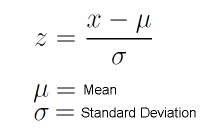

1. Data standardization is the process of rescaling the attributes so that they have a mean of 0 and a variance of 1.
2. The ultimate goal to perform standardization is to bring down all the features to a common scale without distorting the differences in the range of the values.
3. In sklearn.preprocessing.StandardScaler(), centering and scaling happen independently on each feature.

In [37]:
from scipy.stats import zscore
subset_scaled_df=subset_df.apply(zscore)
subset_scaled_df.head(10)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            1.7402             -1.2492            -0.8605   
1            0.4103             -0.7876            -1.4737   
2            0.4103              1.0590            -0.8605   
3           -0.1217              0.1357            -0.8605   
4            1.7402              0.5973            -1.4737   
5           -0.3876             -0.7876            -1.4737   
6            1.7402              0.1357            -1.4737   
7           -0.5206             -0.7876            -1.4737   
8           -0.7866             -1.2492            -1.4737   
9           -0.8398             -0.3259            -1.4737   

   Total_visits_online  Total_calls_made  
0              -0.5475           -1.2515  
1               2.5205            1.8919  
2               0.1343            0.1455  
3              -0.5475            0.1455  
4               3.2023           -0.2037  
5              -0.5475            1.5426  
6               2.8614           -0.5530  
7              -0.5475           -0.9023  
8              -0.2066           -0.5530  
9              -0.5475            1.1933

In [38]:
sc = StandardScaler()
subset_scaled_df1 = pd.DataFrame(sc.fit_transform(subset_df),columns=subset_df.columns)
subset_scaled_df1.head(10)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            1.7402             -1.2492            -0.8605   
1            0.4103             -0.7876            -1.4737   
2            0.4103              1.0590            -0.8605   
3           -0.1217              0.1357            -0.8605   
4            1.7402              0.5973            -1.4737   
5           -0.3876             -0.7876            -1.4737   
6            1.7402              0.1357            -1.4737   
7           -0.5206             -0.7876            -1.4737   
8           -0.7866             -1.2492            -1.4737   
9           -0.8398             -0.3259            -1.4737   

   Total_visits_online  Total_calls_made  
0              -0.5475           -1.2515  
1               2.5205            1.8919  
2               0.1343            0.1455  
3              -0.5475            0.1455  
4               3.2023           -0.2037  
5              -0.5475            1.5426  
6               2.8614           -0.5530  
7              -0.5475           -0.9023  
8              -0.2066           -0.5530  
9              -0.5475            1.1933

* zscore or StandardScaler() will give the same results. So, any method can be used for standardizing the features.

# Unsupervised Learning Model Building for Clustering 

## K-Means Clustering 

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094700983137036
Number of Clusters: 8 	Average Distortion: 0.8922456881128548
Number of Clusters: 9 	Average Distortion: 0.8633274546350456

Cluster Error: [3300.0000000000005, 2040.9898164784952, 933.0437490000534, 780.7736895551768, 704.4759188657506, 642.1490713311521, 600.049543334103, 567.2035125446861, 534.2648682537475]


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

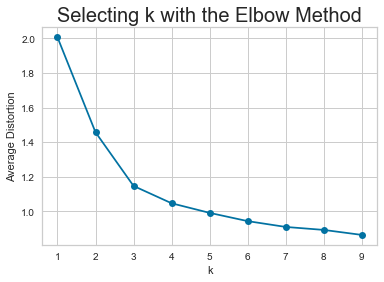

In [39]:
clusters = range(1, 10)
meanDistortions = []  # Create a empty list
errors = [] #Create empty list for errors 

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_scaled_df)  # Fit kMeans on the data
    prediction = model.predict(subset_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above
    
    errors.append(model.inertia_)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

print("\nCluster Error:", errors)

plt.plot(clusters, meanDistortions, "bo-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

### Observation

- From the above Elbow Method graph, the possible number of clusters can be 3 or 4. 
- At k=3 the average distortion is 1.14 and at K=4 we have 1.04.
- But the K value can be decided after checking Silhouette score

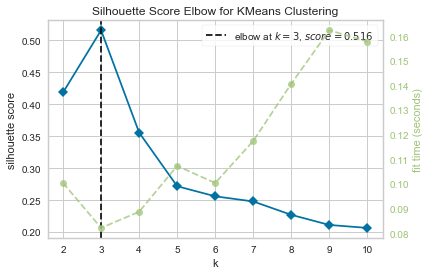

In [40]:
kev = KElbowVisualizer(
    estimator = KMeans(),
    k = 10,
    metric = "silhouette"
    # optional metric : "distortion"(default, "calinski_harabasz"
).fit(subset_scaled_df)

kev.show();

### What is silhouette score?

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. 
* Silhouette score near -1 indicate that those samples might have been assigned to the wrong cluster.

**From the silhouette scores, it seems that 7 is a good value of k.Let's do deeper investigation for different K values using  SilhouetteVisualizer**

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2726898791817692
For n_clusters = 6, silhouette score is 0.25583657571102003
For n_clusters = 7, silhouette score is 0.24847787091758058
For n_clusters = 8, silhouette score is 0.2266798472313902
For n_clusters = 9, silhouette score is 0.21852430691339222


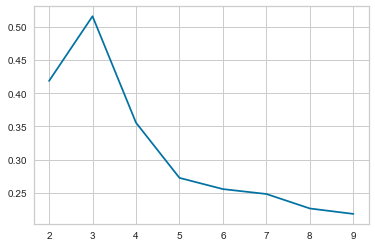

In [41]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_scaled_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

### How to interpret the results of SilhouetteVisualizer?

Below are the points that every cluster needs to satisfy for selecting the optimal K-value.
  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score
  
**Note** 
1. Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)
2. Horizontal line refers to the Silhouette score of each cluster.
3. Dotted red line is an Average Silhouette score. 

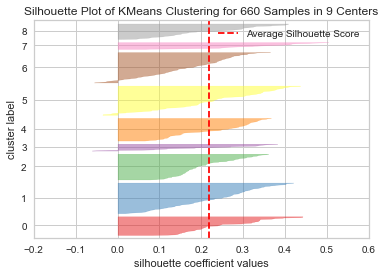

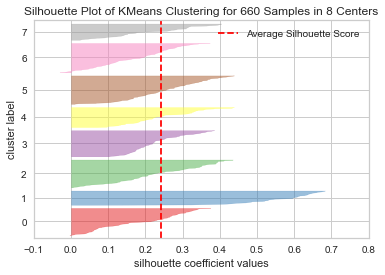

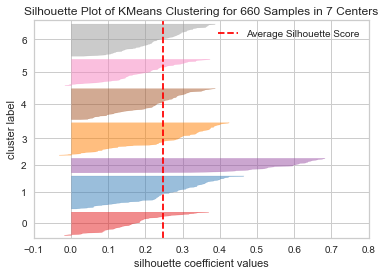

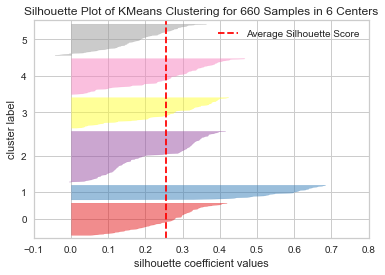

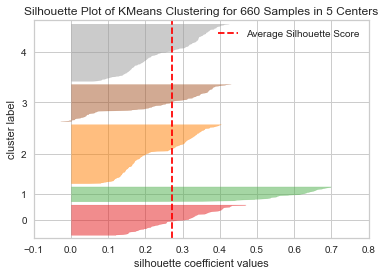

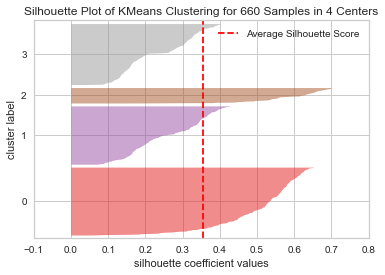

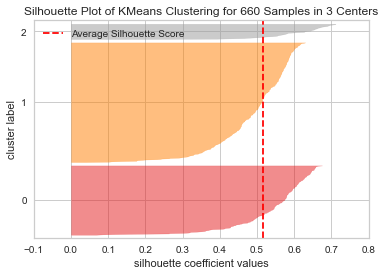

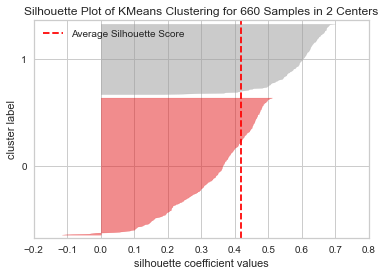

In [42]:
for ii in range(9, 1, -1):
    visualizer = SilhouetteVisualizer(KMeans(ii, random_state=1))
    visualizer.fit(subset_scaled_df)
    visualizer.show()

**Observation**

* From the above plot, we can observe that, all the cluster values are more than the average Silhouette score
* But some clusters are very thin in many cluster value centers. 
* If at all the cluster visualization looks good, but no elbow at many K levels
* So overall K=3 looks good in many ways like above average score, elbow has a knick and cluster size is perfect too. 

### Applying KMeans clustering for k=3

In [43]:
%%time

# Creating Kmeans model with 3 clusters and fitting our scaled data to the the model
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

CPU times: total: 344 ms
Wall time: 102 ms


KMeans(n_clusters=3, random_state=0)

In [44]:
kmeans.labels_

array([0, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

In [46]:
# adding kmeans cluster labels to the original dataframe
subset_df["K_means_segments"] = kmeans.labels_

In [47]:
K_Means_df = df
K_Means_df

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0           87073            100000                   2                  1   
1           38414             50000                   3                  0   
2           17341             50000                   7                  1   
3           40496             30000                   5                  1   
4           47437            100000                   6                  0   
..            ...               ...                 ...                ...   
655         51108             99000                  10                  1   
656         60732             84000                  10                  1   
657         53834            145000                   8                  1   
658         80655            172000                  10                  1   
659         80150            167000                   9                  0   

     Total_visits_online  Total_calls_made  K_means_segments  
0                      1                 0                 0  
1                     10                 9                 1  
2                      3                 4                 0  
3                      1                 4                 0  
4                     12                 3                 2  
..                   ...               ...               ...  
655                   10                 0                 2  
656                   13                 2                 2  
657                    9                 1                 2  
658                   15                 0                 2  
659                   12                 2                 2  

[660 rows x 7 columns]

### Cluster Profiling

In [48]:
df[df["K_means_segments"] == 0]

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0           87073            100000                   2                  1   
2           17341             50000                   7                  1   
3           40496             30000                   5                  1   
228         54838             10000                   7                  2   
229         35254              8000                   7                  2   
..            ...               ...                 ...                ...   
607         90191             34000                   6                  3   
608         49341             47000                   4                  4   
609         11562             38000                   4                  3   
610         16253             39000                   7                  2   
611         80623             46000                   7                  4   

     Total_visits_online  Total_calls_made  K_means_segments  
0                      1                 0                 0  
2                      3                 4                 0  
3                      1                 4                 0  
228                    0                 0                 0  
229                    1                 4                 0  
..                   ...               ...               ...  
607                    1                 0                 0  
608                    1                 0                 0  
609                    2                 0                 0  
610                    1                 0                 0  
611                    1                 3                 0  

[386 rows x 7 columns]

In [49]:
cluster_profile = df.groupby("K_means_segments").mean()

In [50]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Customer Key"].count().values
)

In [51]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments").count().values
)

In [52]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

### Observation

* Cluster 0 has 386 customers
* Cluster 1 has 224 customers
* Cluster 2 has 50 customers

In [53]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= df['Total_visits_bank'],
    y= df['Total_visits_online'],
    z= df['Total_calls_made'],
    mode='markers',
     marker=dict(
        color = df['K_means_segments'], 
        size= 20,
        line=dict(
            color= df['K_means_segments'],
            width= 12
        ),
        opacity=0.8
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'K-Means Clusters',
    scene = dict(
            xaxis = dict(title  = 'Bank Visits'),
            yaxis = dict(title  = 'Online Visits'),
            zaxis = dict(title  = 'Customer Service Calls')
        )
)
fig = go.Figure(data=d, layout=layout)
py.offline.iplot(fig)


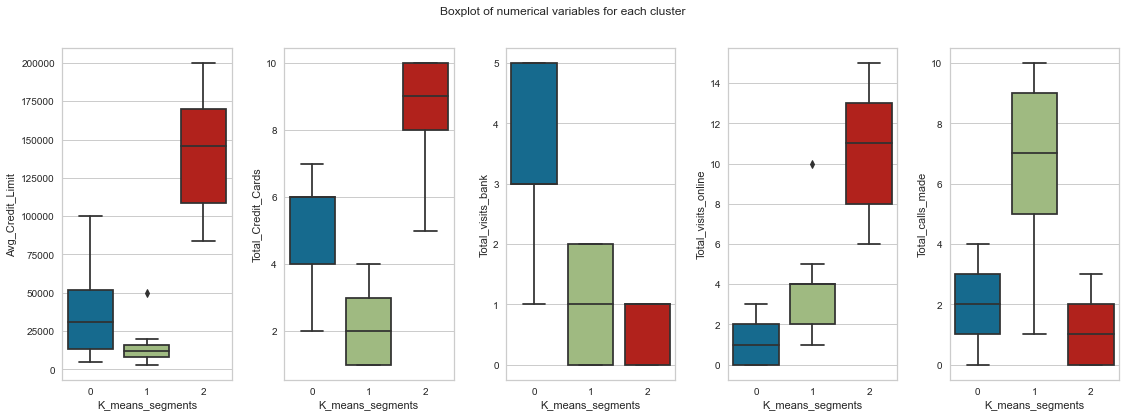

In [54]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_cols[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights of KMeans Clustering

- **Cluster 0**:

- This Cluster customers prefer to handle bank transactions in person rather than calling or doing it online. 
- Also they have the medium number of credit cards and available credit.
- Average Credit Limit is between 33k with 75% of the customers in this cluster\segment have an average >= than 12.5k, and 25% of the customers have an average credit limit >= 50k.
- Total_Credit_Cards range between 2 and 7 with 75% of the customers in this cluster\segment have at least 4 credit cards.
- Total_visits_Bank range betwenn 1 and 5 with 75% of the customers in this cluster\segment visit the bank in person for at least 3 times.
- Total_Visits_Online count range between 0 and 3 with 75% of the customers in this cluster\segment login <=2 times.
- Total_Calls_Made count range between 0 and 4 with 75% of the customers in this cluster\segment calls the bank or customer service department <= 3times.
- Since group 0 use the online banking the least, bank should promote online banking more to group 0 in order for them to use it.


- **Cluster 1**:

- This Cluster Customers prefer to call the bank to solve any issues rather than visiting the bank or online banking.
- Also they have the low number of credit cards and low average credit.
- Average Credit Limit is between 3k and about 20k with 75% of the customers in this cluster\segment have an average <= than 15k.
- Total_Credit_Cards range between 1 and 4 with 75% of the customers in this cluster\segment have at most 3 credit cards..
- Total_visits_Bank range between 0 and 2 and visiting frequency is little less compare to cluster 0.
- Total_Visits_Online count range between 1 and 5 with 75% of the customers in this cluster\segment login <=4 times.
- Total_Calls_Made count range between 1 and 10 with 75% of the customers in this cluster\segment calls the bank or its customer service department at least 5 times.

- **Cluster 2**:

- This Cluster Customers to do online/digital banking to solve their issues rather than calling or visiting the bank. 
- Also they have a high average credit limit and high number of cards. 
- Average Credit Limit is approximately between 80k and 200k with 75% of the customers in this cluster\segment have an average >= than 110k.
- Total_Credit_Cards range between 5 and 10 with 75% of the customers in this cluster\segment have at least 8 credit cards.
- Total_visits_Bank range betwenn 0 and 1, customers in this cluster rarely visit the bank in person and have the lowest in person bank visiting frequency.
- Total_Visits_Online count range between 6 and 15 with 75% of the customers in this cluster\segment at least 8 times.
- Total_Calls_Made count range between 0 and 3 with 75% of the customers in this cluster\segment calls the bank or its customer service department at most 2 times.

## PCA  - Principal Component Analysis

In [55]:
covMatrix = np.cov(subset_scaled_df,rowvar=False)
print(covMatrix)

[[ 1.00151745  0.60978441 -0.10046453  0.55222122 -0.41498065]
 [ 0.60978441  1.00151745  0.31627526  0.16801286 -0.65223974]
 [-0.10046453  0.31627526  1.00151745 -0.55269882 -0.50678371]
 [ 0.55222122  0.16801286 -0.55269882  1.00151745  0.12749255]
 [-0.41498065 -0.65223974 -0.50678371  0.12749255  1.00151745]]


In [56]:
pca = PCA(n_components=5)
pca.fit(subset_scaled_df)

PCA(n_components=5)

In [57]:
#The eigen Values
print(pca.explained_variance_)

[2.29029906 1.87416377 0.3205531  0.27826563 0.24430569]


In [58]:
#The eigen Vectors
print(pca.components_)

[[ 0.48885901  0.59767943  0.28049227  0.11178284 -0.55912866]
 [ 0.40323959  0.03017103 -0.58658661  0.66516108  0.22352726]
 [ 0.00346147 -0.28498293 -0.6135219  -0.3049481  -0.67035086]
 [ 0.30861651 -0.74135216  0.44527763  0.31838769 -0.23560546]
 [-0.70933671  0.10512237  0.05058609  0.59220036 -0.36404738]]


In [59]:
#And the percentage of variation explained by each eigen Vector
print(pca.explained_variance_ratio_)

[0.45736578 0.37426483 0.06401348 0.0555688  0.04878711]


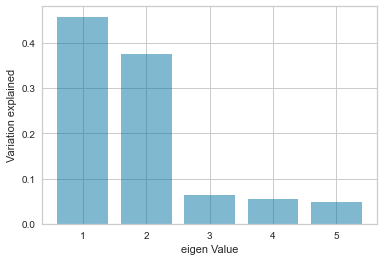

In [60]:
plt.bar(list(range(1,6)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

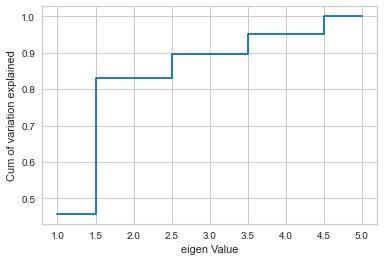

In [61]:
plt.step(list(range(1,6)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

## Dimensionality Reduction

Now 3 dimensions seems very reasonable. With 3 variables we can explain over 95% of the variation in the original data!

In [62]:
pca3 = PCA(n_components=3)
pca3.fit(subset_scaled_df)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(subset_scaled_df)

[[ 0.48885901  0.59767943  0.28049227  0.11178284 -0.55912866]
 [ 0.40323959  0.03017103 -0.58658661  0.66516108  0.22352726]
 [ 0.00346147 -0.28498293 -0.6135219  -0.3049481  -0.67035086]]
[0.45736578 0.37426483 0.06401348]


In [63]:
PCA_df = pd.DataFrame(Xpca3)
PCA_df.head()

0      1       2
0  0.5013 0.5248  1.8959
1 -1.4596 3.1056 -0.9068
2  0.5258 0.8240  0.0890
3 -0.3623 0.1281  0.5582
4  1.2662 3.6687 -0.1000

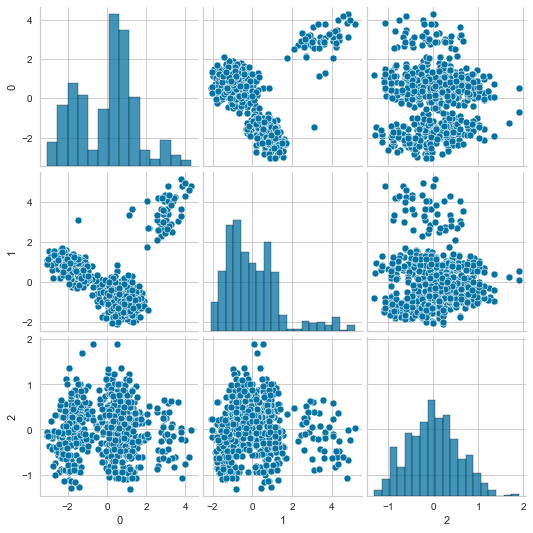

In [64]:
sns.pairplot(PCA_df)

# Hierarchical Clustering

* It is a Connectivity based clustering which creates clusters in a hierarchical tree like structure
* Any type of distance measure can be used as a measure of similarity.
* The Cluster tree like output is called Dendogram.

Let's find the Cophenetic correlation for different distances with different linkage methods.

### What is Cophenetic correlation? 

The cophenetic correlation coefficient is a correlation coefficient between the cophenetic distances(Dendrogramic distance) obtained from the tree, and the original distances used to construct the tree. It is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points. 

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.

Cophenetic correlation is the way to compare two or more dendrograms. 

In [65]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [66]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [67]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [68]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

**Let's see the dendrograms for the different linkage methods.**

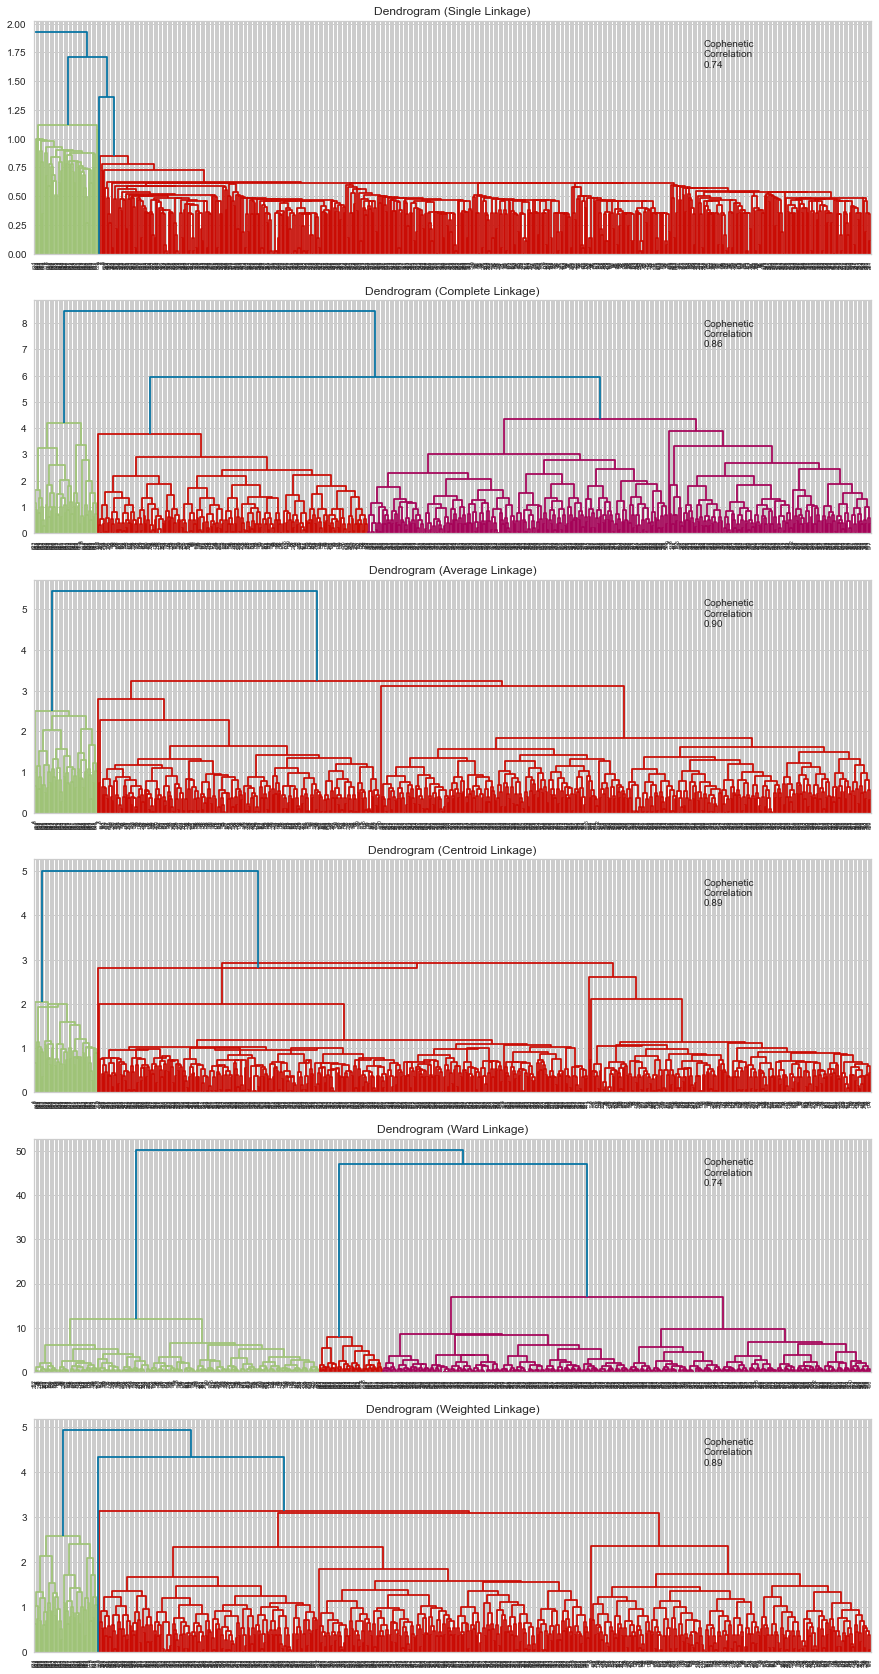

In [69]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average and centroid, weighted linkage methods have almost equal correlation.
- 3 clusters appears to be the appropriate number of clusters from the dendrogram for Average linkage.
- So, We will move ahead with average linkage and 3 clusters.

Observations

- It looks like Ward linkage has more distinct and separated clusters.
- The cophenetic correlation is highest for average linkage method.
- We will move ahead with average linkage for now and see how well the clusters were profiled.
- Let's check the best number of clusters for this method from the dendogram. The longest vertical distance without any horizontal line passing through it is represented by the left blue leg, therefore this leg\line is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters.

**The optimal number of clusters from a dendrogram can be obtained by deciding where to cut the cluster tree. Generally, the cluster tree is cut where dendrogram height is maximum as it generally corresponds to distinct and homogeneous clusters.
The dendrogram for average linkage had the highest cophenetic correlation. So we can use average linkage and have chosen 3 clusters as the dendrogram height is pretty high. (The maximum height is for 2, but that would not be meaningful as it would give one clusters with too many data and its hard to contact customers as per their preferences).**

**Lets visualize the dendrogram cut for average link in the below plot**

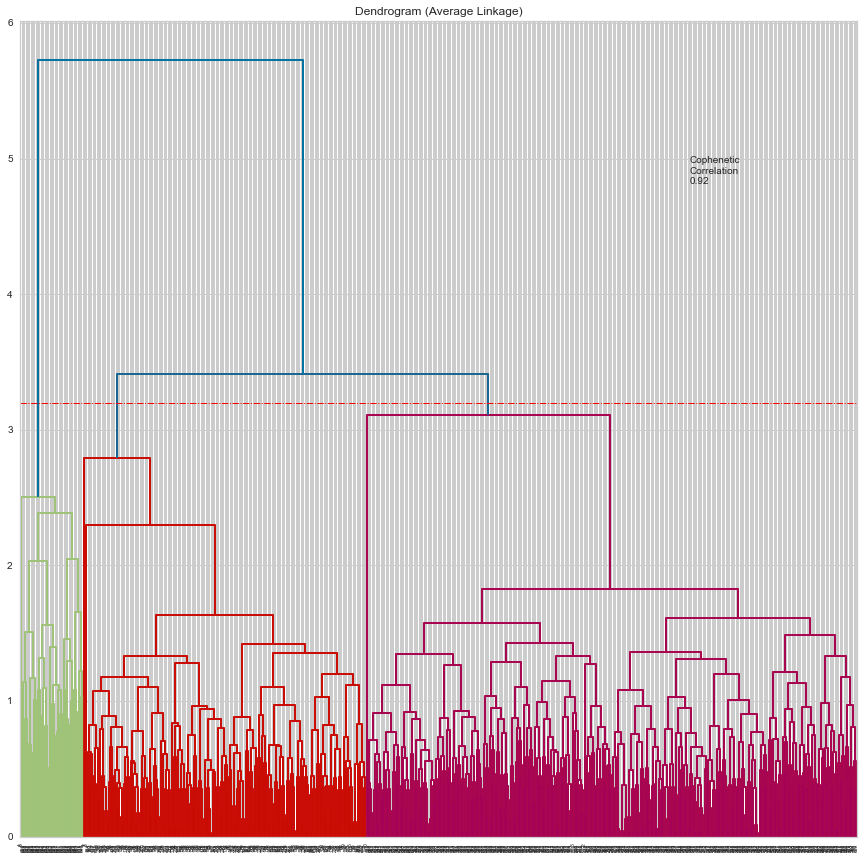

In [91]:
# list of linkage methods
linkage_methods = ["average"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=3.2)
plt.axhline(y=3.2, c="red", lw=1, linestyle="dashdot")

## Hierarchical Clustering

In [71]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [72]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

In [73]:
HC_Model_df = df
HC_Model_df

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0           87073            100000                   2                  1   
1           38414             50000                   3                  0   
2           17341             50000                   7                  1   
3           40496             30000                   5                  1   
4           47437            100000                   6                  0   
..            ...               ...                 ...                ...   
655         51108             99000                  10                  1   
656         60732             84000                  10                  1   
657         53834            145000                   8                  1   
658         80655            172000                  10                  1   
659         80150            167000                   9                  0   

     Total_visits_online  Total_calls_made  K_means_segments  HC_Clusters  
0                      1                 0                 0            0  
1                     10                 9                 1            2  
2                      3                 4                 0            0  
3                      1                 4                 0            0  
4                     12                 3                 2            1  
..                   ...               ...               ...          ...  
655                   10                 0                 2            1  
656                   13                 2                 2            1  
657                    9                 1                 2            1  
658                   15                 0                 2            1  
659                   12                 2                 2            1  

[660 rows x 8 columns]

## Cluster Profiling

In [74]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [75]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Customer Key"].count().values
)

In [76]:
df['HC_Clusters'].value_counts()

0    387
2    223
1     50
Name: HC_Clusters, dtype: int64

**Average linkage seems have a good cluster, but ward always give homogeneous clusters. So we can just try with ward.**

**Lets visualize the dendrogram cut for ward linkage in the below plot**

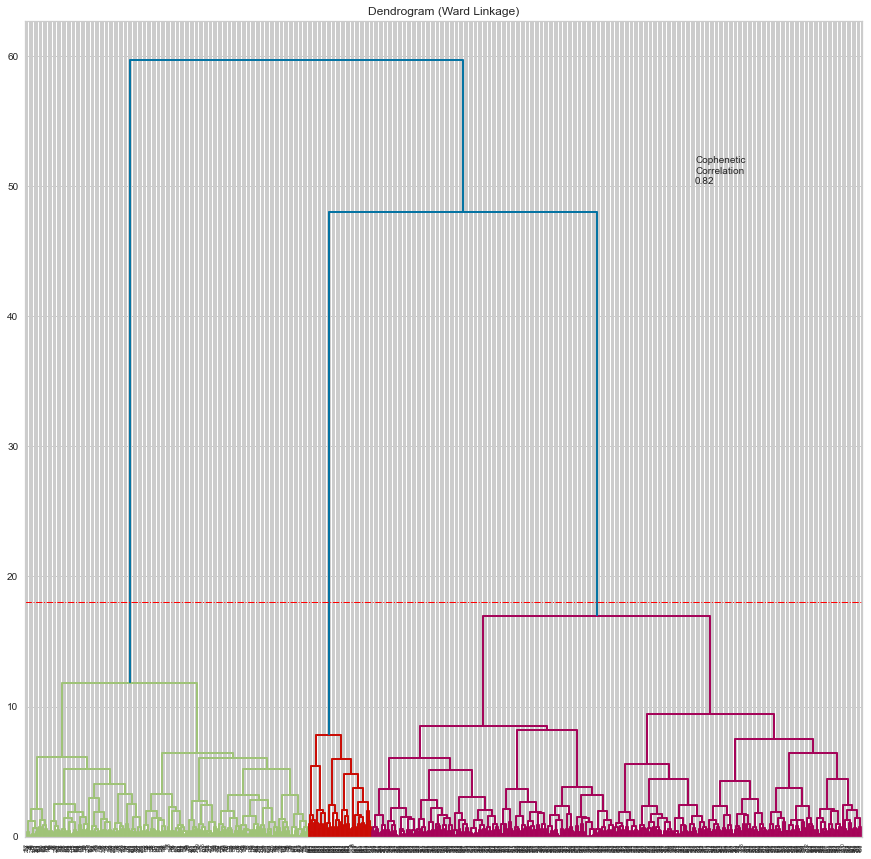

In [77]:
# list of linkage methods
linkage_methods = ["ward"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=18)
plt.axhline(y=18, c="red", lw=1, linestyle="dashdot")

In [92]:
%%time 
# Agglomerative Clustering with 3 clusters, ward linkage and euclidean as the metric 
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

# Calculting the silhouette score for the Agglomerative clustering
print(silhouette_score(subset_scaled_df, HCmodel.labels_, metric="euclidean"))

0.5413025796835845
CPU times: total: 78.1 ms
Wall time: 52.6 ms


In [93]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

In [94]:
df['HC_Clusters'].value_counts()

0    387
1    223
2     50
Name: HC_Clusters, dtype: int64

## Cluster Profiling

In [95]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [96]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Customer Key"].count().values
)

In [97]:
# let's see the names of the countries in each cluster
for cl in df["HC_Clusters"].unique():
    print(
        "The",
        df[df["HC_Clusters"] == cl]["Customer Key"].nunique(),
        "countries in cluster",
        cl,
        "are:",
    )
    print(df[df["HC_Clusters"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 385 countries in cluster 0 are:
[87073 17341 40496 54838 35254 46635 97825 83125 35483 15129 83290 56486
 31903 45909 14263 46813 81878 35549 85799 39122 81531 69965 18595 44398
 32352 40898 27101 33457 45088 23302 27408 65372 21531 56843 17165 89328
 20072 71402 47496 24808 17036 67193 34423 97109 55382 51811 53936 66504
 53207 18514 51319 36340 36934 95925 49771 22919 21233 74544 52025 45652
 73952 49418 77026 49331 75775 54906 94666 11698 34677 95610 41380 38033
 85337 38994 67911 92956 77641 57565 53814 30712 19785 31384 16374 50878
 78002 83459 91987 51552 72156 24998 45673 11596 87485 28414 81863 33240
 11466 23881 44645 49844 92782 22824 26767 26678 50412 17933 34495 47437
 22610 41159 64672 62483 85614 96548 19137 69028 70779 38244 67046 64897
 46223 36628 17565 77381 11799 81940 66706 87838 94437 33790 44402 29886
 66804 47866 61996 15318 89635 71681 71862 96186 22348 36243 88807 82376
 98126 80347 17649 62807 92522 57459 44579 45476 61994 11398 24702 27824
 45878 72431 19

**Both linkage method average & ward have almost same type of clusters. So we can use anything.**

In [98]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

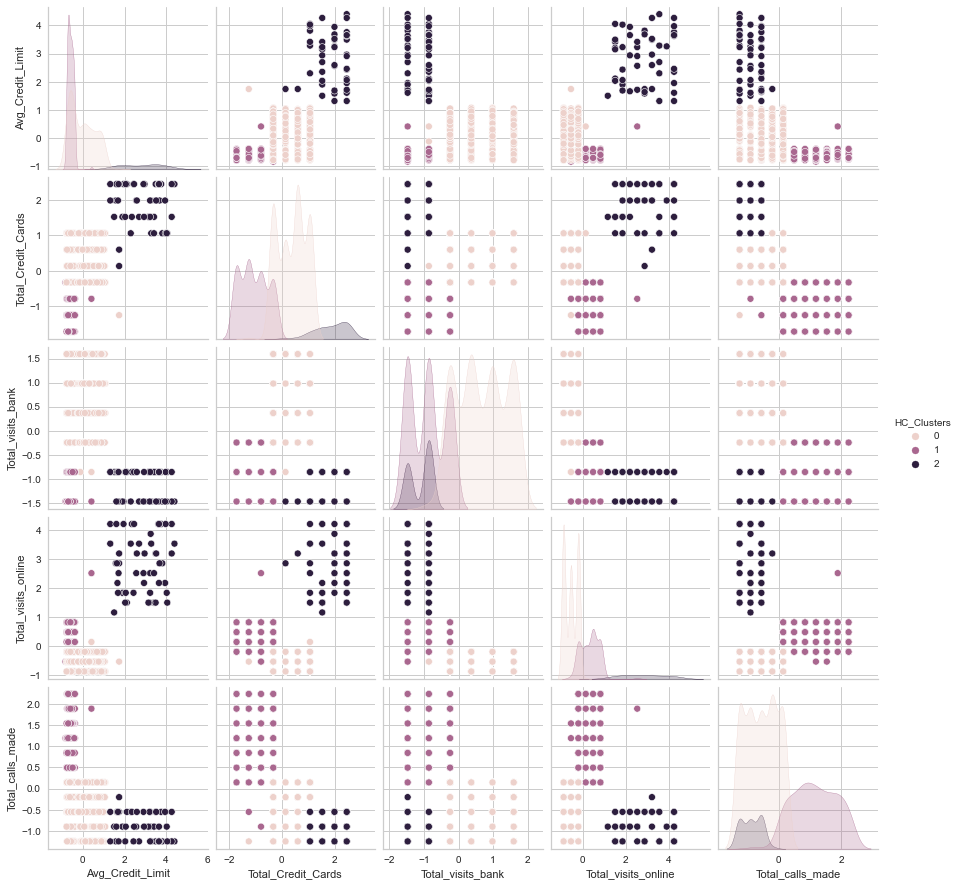

In [99]:
sns.pairplot(subset_scaled_df, diag_kind='kde', hue='HC_Clusters');

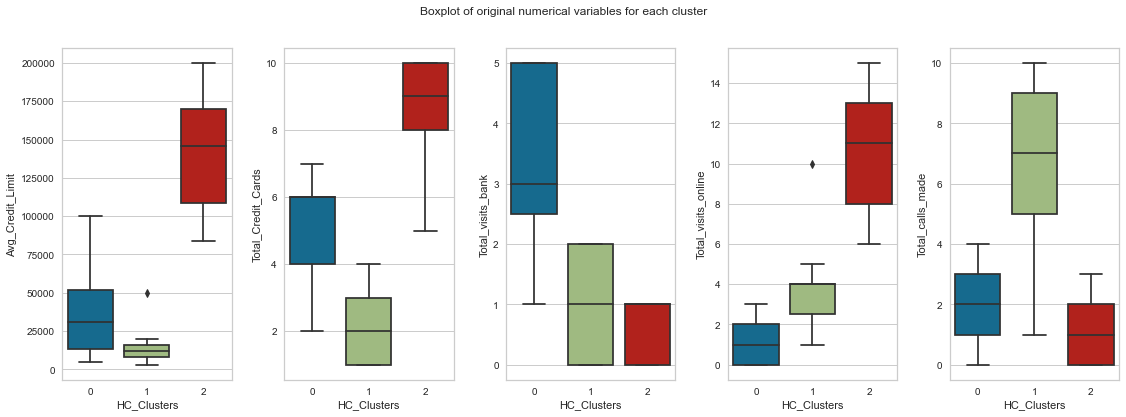

In [100]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=df[num_cols[counter]],
        x=df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights of Hierarchical Clustering

- **Cluster 0**:

- This Cluster customers prefer to handle bank transactions in person rather than calling or doing it online. 
- Also they have the medium number of credit cards and available credit.
- Average Credit Limit is between 33k with 75% of the customers in this cluster\segment have an average >= than 12.5k, and 25% of the customers have an average credit limit >= 50k.
- Total_Credit_Cards range between 2 and 7 with 75% of the customers in this cluster\segment have at least 4 credit cards.
- Total_visits_Bank range between 1 and 5 with 75% of the customers in this cluster\segment visit the bank in person for at least 3 times.
- Total_Visits_Online count range between 0 and 3 with 75% of the customers in this cluster\segment login <=2 times.
- Total_Calls_Made count range between 0 and 4 with 75% of the customers in this cluster\segment calls the bank or customer service department <= 3times.
- Since group 0 use the online banking the least, bank should promote online banking more to group 0 in order for them to use it.


- **Cluster 1**:

- This Cluster Customers prefer to call the bank to solve any issues rather than visiting the bank or online banking.
- Also they have the low number of credit cards and low average credit.
- Average Credit Limit is between 3k and about 20k with 75% of the customers in this cluster\segment have an average <= than 15k.
- Total_Credit_Cards range between 1 and 4 with 75% of the customers in this cluster\segment have at most 3 credit cards..
- Total_visits_Bank range between 0 and 2 and visiting frequency is little less compare to cluster 0.
- Total_Visits_Online count range between 1 and 5 with 75% of the customers in this cluster\segment login <=4 times.
- Total_Calls_Made count range between 1 and 10 with 75% of the customers in this cluster\segment calls the bank or its customer service department at least 5 times.

- **Cluster 2**:

- This Cluster Customers do online/digital banking to solve their issues rather than calling or visiting the bank. 
- Also they have a high average credit limit and high number of cards. 
- Average Credit Limit is approximately between 80k and 200k with 75% of the customers in this cluster\segment have an average >= than 110k.
- Total_Credit_Cards range between 5 and 10 with 75% of the customers in this cluster\segment have at least 8 credit cards.
- Total_visits_Bank range betwenn 0 and 1, customers in this cluster rarely visit the bank in person and have the lowest in person bank visiting frequency.
- Total_Visits_Online count range between 6 and 15 with 75% of the customers in this cluster\segment at least 8 times.
- Total_Calls_Made count range between 0 and 3 with 75% of the customers in this cluster\segment calls the bank or its customer service department at most 2 times.

# Additional Analysis 

In [101]:
PCA_Cluster_df = PCA_df.copy()
PCA_Cluster_df['PCA_HC_Clusters'] = HCmodel.labels_

#Renaming the columns for easy identification
PCA_Cluster_df = PCA_Cluster_df.rename(columns={0:'component_1', 1:'component_2', 2:'component_3'})

PCA_Cluster_df

component_1  component_2  component_3  PCA_HC_Clusters
0         0.5013       0.5248       1.8959                0
1        -1.4596       3.1056      -0.9068                1
2         0.5258       0.8240       0.0890                0
3        -0.3623       0.1281       0.5582                0
4         1.2662       3.6687      -0.1000                2
..           ...          ...          ...              ...
655       3.0385       2.6662      -0.0923                2
656       2.5672       3.3417      -0.8738                2
657       2.8514       2.9831       0.0449                2
658       4.1783       4.5829      -0.6053                2
659       3.1604       4.3510      -0.2544                2

[660 rows x 4 columns]

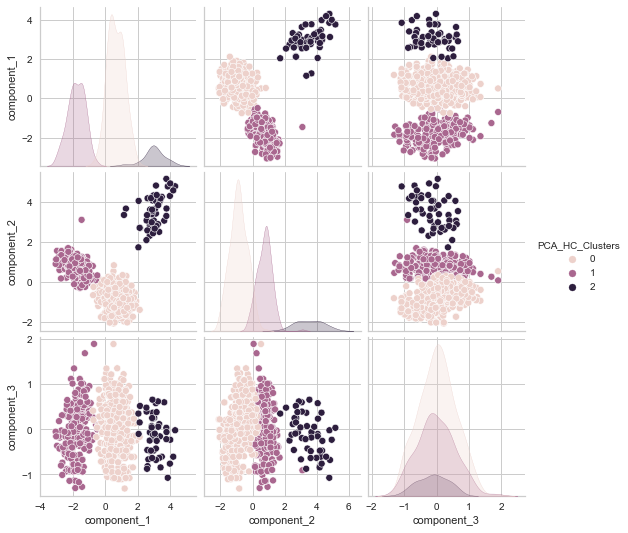

In [102]:
sns.pairplot(PCA_Cluster_df, diag_kind='kde', hue='PCA_HC_Clusters');

In [103]:
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= PCA_Cluster_df['component_1'],
    y= PCA_Cluster_df['component_2'],
    z= PCA_Cluster_df['component_3'],
    mode='markers',
     marker=dict(
        color = PCA_Cluster_df['PCA_HC_Clusters'], 
        size= 20,
        line=dict(
            color= PCA_Cluster_df['PCA_HC_Clusters'],
            width= 12
        ),
        opacity=0.8
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'PCA HC Clusters',
    scene = dict(
            xaxis = dict(title  = 'Component 1'),
            yaxis = dict(title  = 'Component 2'),
            zaxis = dict(title  = 'Component 3')
        )
)
fig = go.Figure(data=d, layout=layout)
py.offline.iplot(fig)

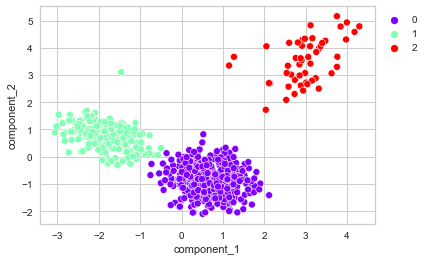

In [113]:
sns.scatterplot(
    data=PCA_Cluster_df,
    x="component_1",
    y="component_2",
    hue="PCA_HC_Clusters",
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

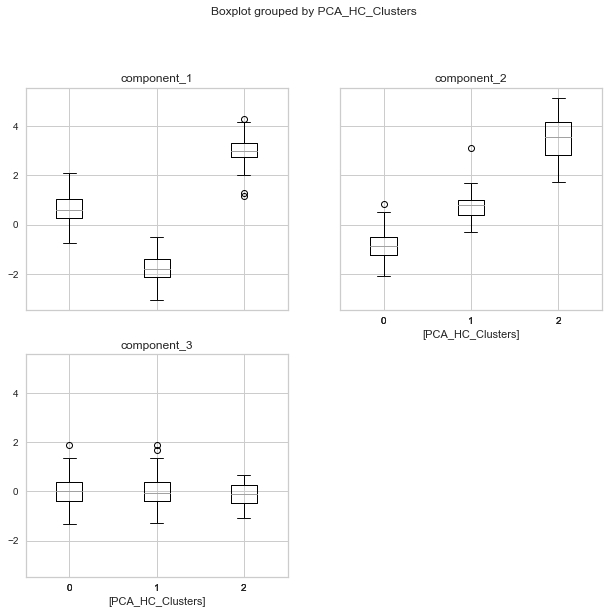

In [114]:
PCA_Cluster_df.boxplot(by='PCA_HC_Clusters', layout=(3,2), figsize=(10,14));

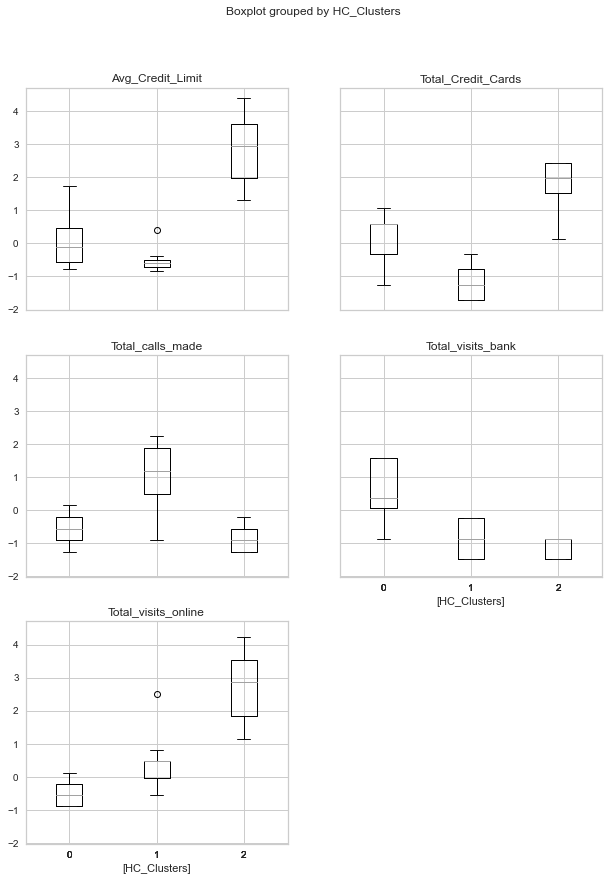

In [115]:
subset_scaled_df.boxplot(by='HC_Clusters', layout=(3,2), figsize=(10,14));

### Analyzing the duplicated Customer Key

In [116]:
df[df["Customer Key"].isin([47437, 37252, 97935, 96929, 50706])].sort_values('Customer Key')

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
48          37252              6000                   4                  0   
432         37252             59000                   6                  2   
4           47437            100000                   6                  0   
332         47437             17000                   7                  3   
411         50706             44000                   4                  5   
541         50706             60000                   7                  5   
391         96929             13000                   4                  5   
398         96929             67000                   6                  2   
104         97935             17000                   2                  1   
632         97935            187000                   7                  1   

     Total_visits_online  Total_calls_made  K_means_segments  HC_Clusters  
48                     2                 8                 1            1  
432                    1                 2                 0            0  
4                     12                 3                 2            2  
332                    1                 0                 0            0  
411                    0                 2                 0            0  
541                    2                 2                 0            0  
391                    0                 0                 0            0  
398                    2                 2                 0            0  
104                    2                10                 1            1  
632                    7                 0                 2            2

Observations

* The above Customer key are duplicate records with different values in all the other features
* But three customer 47437, 37252, 97935 are assigned to different clusters
* So bank should try to fix it, otherwise they will be approached by different markerting teams
* If they are really different customers, then the Customer Key needs to be fixed as its a unique value. 


# Comparison of KMeans and Hierarchical Clustering

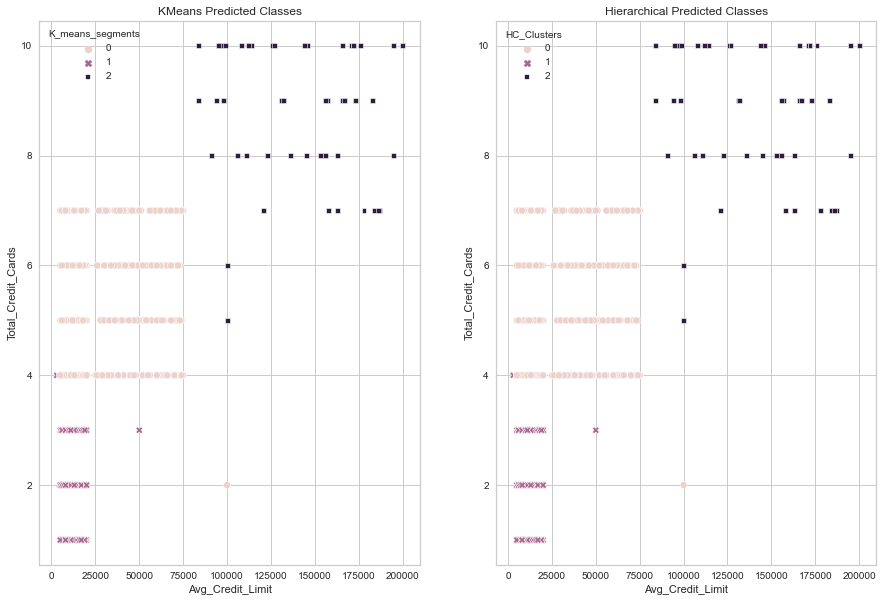

In [117]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))

ax1 = plt.subplot(1,2,1)
plt.title('KMeans Predicted Classes')
sns.scatterplot(x='Avg_Credit_Limit', y='Total_Credit_Cards', style='K_means_segments', hue='K_means_segments',data=K_Means_df,ax=ax1)

ax2 = plt.subplot(1,2,2)
plt.title('Hierarchical Predicted Classes')
sns.scatterplot(x='Avg_Credit_Limit', y='Total_Credit_Cards', style = 'HC_Clusters',hue='HC_Clusters', data=HC_Model_df, ax=ax2)

plt.show()

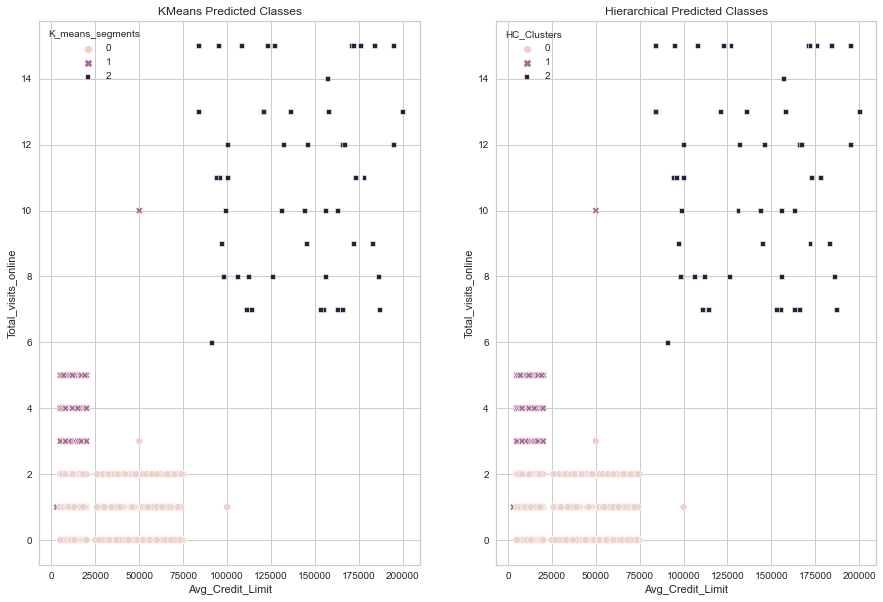

In [118]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))

ax1 = plt.subplot(1,2,1)
plt.title('KMeans Predicted Classes')
sns.scatterplot(x='Avg_Credit_Limit', y='Total_visits_online', style='K_means_segments', hue='K_means_segments',data=K_Means_df,ax=ax1)

ax2 = plt.subplot(1,2,2)
plt.title('Hierarchical Predicted Classes')
sns.scatterplot(x='Avg_Credit_Limit', y='Total_visits_online', style = 'HC_Clusters',hue='HC_Clusters', data=HC_Model_df, ax=ax2)

plt.show()

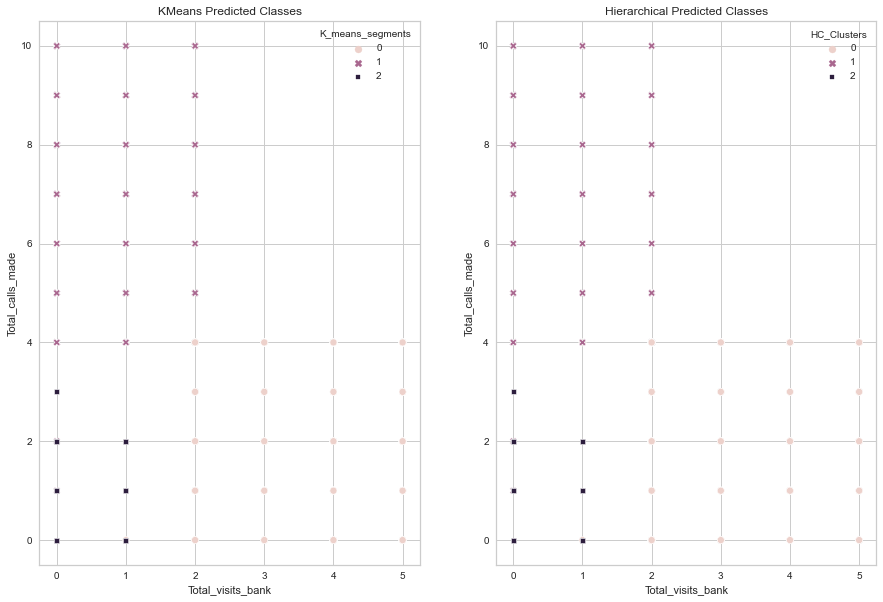

In [119]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))

ax1 = plt.subplot(1,2,1)
plt.title('KMeans Predicted Classes')
sns.scatterplot(x='Total_visits_bank', y='Total_calls_made', style='K_means_segments', hue='K_means_segments',data=K_Means_df,ax=ax1)

ax2 = plt.subplot(1,2,2)
plt.title('Hierarchical Predicted Classes')
sns.scatterplot(x='Total_visits_bank', y='Total_calls_made', style = 'HC_Clusters',hue='HC_Clusters', data=HC_Model_df, ax=ax2)

plt.show()

### Comparing K-means and Agglomerative clustering

* K Means clustering needed advance knowledge of K i.e. no. of clusters one want to divide your data.In hierarchical clustering one can stop at any number of clusters, one find appropriate by interpreting the dendrogram.

* K-Means Clustering is Centroid based, Hierarchical Clustering is partition-based and can either be divisive (Top-down) or agglomerative(bottom-up).

* K-Means Clustering - The Elbow method used to find clusters Hierarchical Clustering - Dendrogram is used

* But The results of both of our clustering are almost similar for this dataset.

* It might be possible to see a difference, when we have a very large dataset and that shape of clusters may differ a little.


**Time for execution:**
- K-means took 102ms and Agglomerative clustering took 53ms.

**Distinct clusters:**
- Both clustering technique KMeans and Agglomerative gave same clusters.

**Silhouette scores:**
- K-means clustering had a better silhoutte score with 0.51 compared to the 0.54 for the agglomerative clustering.

**Number of observations:**

There are almost similar clusters in both algorithms. Below are the counts.

- Cluster 0 has 386 customers in KMeans and 387 in Agglomerative. 
- Cluster 1 has 224 customers in KMeans and 223 in Agglomerative. 
- Cluster 2 has 50 customers in KMeans and 50 in Agglomerative. 

# Business recommendations and insights

* AllLife bank can use any clustering technique KMeans or Hierarchical in segmenting its customers base, since both are equally optimal with respect to efficient(time wise), distinct clusters, and silhouette score.

* As we see there are three categories/segments of customers with each segment having a preference for communication channel with bank, it is recommended that products are marketed to specific segment of customers through their preferred channel. 

* Also, additional services can be provided based on how they connect with bank and also based on their spending pattern which can deduced from average credit limit.

* At the same time the bank should try to increase the credit limit and the number of credit cards for customers in these cluters perhaps by offering incentives, bonuses, or waiving some fees. 

* This approach should be more intensive to customers in cluster 0 since customers in cluster 0 have the least credit limit and the least number of cards..

* Customers with high credit limit tend to vist online. Hence they can be targeted for online campaigns, coupons and accordingly products and services can be offered to them

* Whereas customers with comparatively low credit limit make visits to bank more often, hence they can either be prompted with benefits of online banking or can be catered with in-bank offers/services and flyers

* Customers with low credit limits have less frequency on online platform, they can be marketed with benefits of online banking and/or make customer call center reps aware of promotions and offers so that they can target this segment of customers

* Based on how bank wants to promote its products and services, a segment of customers can be targeted as we know their prefered mode of commmunication with bank

In [120]:
Z

array([[ 464.        ,  497.        ,    0.        ,    2.        ],
       [ 250.        ,  361.        ,    0.        ,    2.        ],
       [ 252.        ,  324.        ,    0.        ,    2.        ],
       ...,
       [   0.        , 1309.        ,    3.11135778,  387.        ],
       [1315.        , 1316.        ,    3.41083265,  610.        ],
       [1314.        , 1317.        ,    5.72678778,  660.        ]])

In [121]:
from scipy.spatial.distance import pdist, squareform
squareform(cophenet(Z))

array([[0.        , 3.41083265, 3.11135778, ..., 5.72678778, 5.72678778,
        5.72678778],
       [3.41083265, 0.        , 3.41083265, ..., 5.72678778, 5.72678778,
        5.72678778],
       [3.11135778, 3.41083265, 0.        , ..., 5.72678778, 5.72678778,
        5.72678778],
       ...,
       [5.72678778, 5.72678778, 5.72678778, ..., 0.        , 2.3870557 ,
        1.11695686],
       [5.72678778, 5.72678778, 5.72678778, ..., 2.3870557 , 0.        ,
        2.3870557 ],
       [5.72678778, 5.72678778, 5.72678778, ..., 1.11695686, 2.3870557 ,
        0.        ]])